<a href="https://colab.research.google.com/github/thanachin/exxon/blob/main/Predict_STOCK_SELL_VALUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Global Imports and Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

from typing import Dict, Tuple

import warnings
warnings.filterwarnings('ignore')

# Set random seed
random_state = 42

In [ ]:
df = pd.read_csv('/content/inventory_outlier.csv')
df.head()

,BALANCE_AS_OF_DATE,PLANT_NAME,MATERIAL_NAME,BATCH_NUMBER,UNRESRICTED_STOCK,STOCK_UNIT,STOCK_SELL_VALUE,CURRENCY
0,12/31/2023,CHINA-WAREHOUSE,MAT-0195,8887,133300,KG,418562,CNY
1,12/31/2023,CHINA-WAREHOUSE,MAT-0098,8715A,156575,KG,349162,CNY
2,12/31/2023,CHINA-WAREHOUSE,MAT-0198,9399,157875,KG,495728,CNY
3,12/31/2023,CHINA-WAREHOUSE,MAT-0261,P7905A,203875,KG,1451590,CNY
4,12/31/2023,CHINA-WAREHOUSE,MAT-0142,V4933A,188850,KG,2005587,CNY


In [ ]:
# Apply currency conversion to 'STOCK_SELL_VALUE'
def convert_to_usd(row):
    cost = row['STOCK_SELL_VALUE']
    if row['PLANT_NAME'] == 'CHINA-WAREHOUSE':
        return cost / 7.85  # Example conversion rate
    elif row['PLANT_NAME'] == 'SINGAPORE-WAREHOUSE':
        return cost * 0.14  # Example conversion rate
    else:
        return cost # Return original value if no conversion is defined

df['STOCK_SELL_VALUE_USD'] = df.apply(convert_to_usd, axis=1)

display(df.head())

,BALANCE_AS_OF_DATE,PLANT_NAME,MATERIAL_NAME,BATCH_NUMBER,UNRESRICTED_STOCK,STOCK_UNIT,STOCK_SELL_VALUE,CURRENCY,STOCK_SELL_VALUE_USD
0,12/31/2023,CHINA-WAREHOUSE,MAT-0195,8887,133300,KG,418562,CNY,53320.000000
1,12/31/2023,CHINA-WAREHOUSE,MAT-0098,8715A,156575,KG,349162,CNY,44479.235669
2,12/31/2023,CHINA-WAREHOUSE,MAT-0198,9399,157875,KG,495728,CNY,63150.063694
3,12/31/2023,CHINA-WAREHOUSE,MAT-0261,P7905A,203875,KG,1451590,CNY,184915.923567
4,12/31/2023,CHINA-WAREHOUSE,MAT-0142,V4933A,188850,KG,2005587,CNY,255488.789809


In [ ]:
df.describe()

,UNRESRICTED_STOCK,STOCK_SELL_VALUE,STOCK_SELL_VALUE_USD
count,9.405000e+03,9.405000e+03,9.405000e+03
mean,1.010342e+05,1.069036e+06,1.368281e+05
std,1.455428e+05,6.636539e+06,8.455502e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.300000e+04,1.159950e+05,1.517006e+04
50%,6.600000e+04,2.299050e+05,2.963520e+04
75%,1.021250e+05,5.855320e+05,7.483669e+04
max,1.853500e+06,1.114501e+08,1.419746e+07


In [ ]:
df.info()
print("\nUnique values in PLANT_NAME:", df['PLANT_NAME'].nunique())
print("Unique values in MATERIAL_NAME:", df['MATERIAL_NAME'].nunique())
print("\nValue counts for PLANT_NAME:")
print(df['PLANT_NAME'].value_counts())
print("\nValue counts for MATERIAL_NAME (Top 20):")
print(df['MATERIAL_NAME'].value_counts().head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9405 entries, 0 to 9404
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   BALANCE_AS_OF_DATE    9405 non-null   object 
 1   PLANT_NAME            9405 non-null   object 
 2   MATERIAL_NAME         9405 non-null   object 
 3   BATCH_NUMBER          9405 non-null   object 
 4   UNRESRICTED_STOCK     9405 non-null   int64  
 5   STOCK_UNIT            9405 non-null   object 
 6   STOCK_SELL_VALUE      9405 non-null   int64  
 7   CURRENCY              9405 non-null   object 
 8   STOCK_SELL_VALUE_USD  9405 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 661.4+ KB

Unique values in PLANT_NAME: 2
Unique values in MATERIAL_NAME: 291

Value counts for PLANT_NAME:
PLANT_NAME
CHINA-WAREHOUSE        8045
SINGAPORE-WAREHOUSE    1360
Name: count, dtype: int64

Value counts for MATERIAL_NAME (Top 20):
MATERIAL_NAME
MAT-0332    401
MAT-00

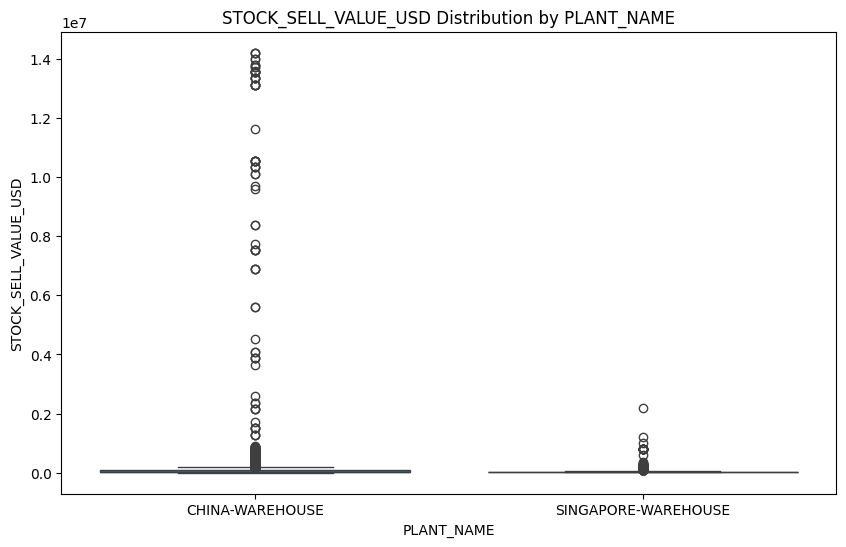

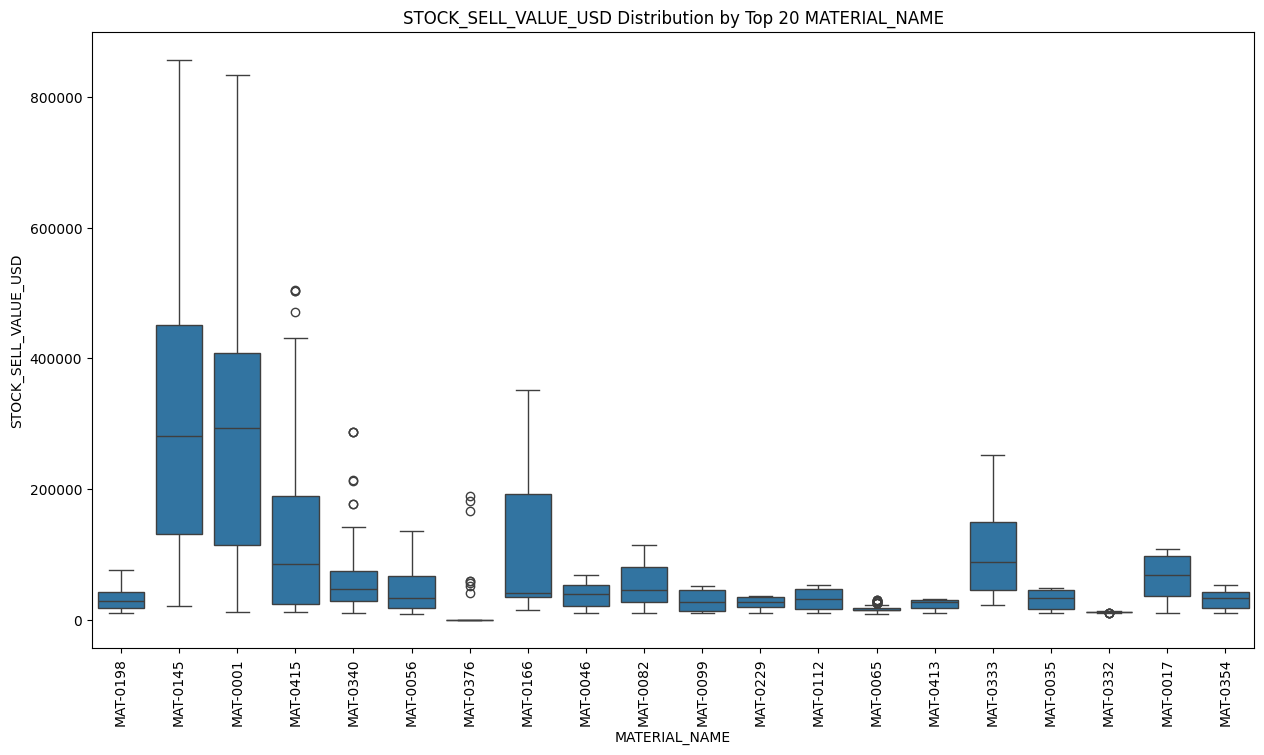

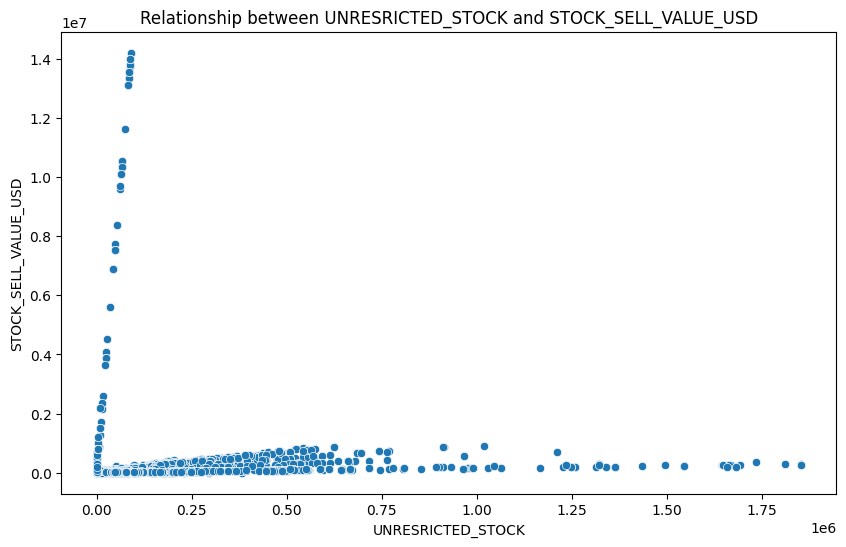

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='PLANT_NAME', y='STOCK_SELL_VALUE_USD', data=df)
plt.title('STOCK_SELL_VALUE_USD Distribution by PLANT_NAME')
plt.show()

top_materials = df['MATERIAL_NAME'].value_counts().head(20).index
df_top_materials = df[df['MATERIAL_NAME'].isin(top_materials)]

plt.figure(figsize=(15, 8))
sns.boxplot(x='MATERIAL_NAME', y='STOCK_SELL_VALUE_USD', data=df_top_materials)
plt.title('STOCK_SELL_VALUE_USD Distribution by Top 20 MATERIAL_NAME')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='UNRESRICTED_STOCK', y='STOCK_SELL_VALUE_USD', data=df)
plt.title('Relationship between UNRESRICTED_STOCK and STOCK_SELL_VALUE_USD')
plt.show()

**Reasoning**:
Apply one-hot encoding to categorical columns, handle outliers using IQR for numerical columns, and split the data into training and testing sets as per the instructions.



In [ ]:
# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['PLANT_NAME', 'MATERIAL_NAME'], drop_first=True)

# Handle outliers using IQR for UNRESRICTED_STOCK and STOCK_SELL_VALUE_USD on the encoded data
Q1_stock = df_encoded['UNRESRICTED_STOCK'].quantile(0.25)
Q3_stock = df_encoded['UNRESRICTED_STOCK'].quantile(0.75)
IQR_stock = Q3_stock - Q1_stock

Q1_value = df_encoded['STOCK_SELL_VALUE_USD'].quantile(0.25)
Q3_value = df_encoded['STOCK_SELL_VALUE_USD'].quantile(0.75)
IQR_value = Q3_value - Q1_value

df_filtered = df_encoded[
    (df_encoded['UNRESRICTED_STOCK'] >= (Q1_stock - 1.5 * IQR_stock)) &
    (df_encoded['UNRESRICTED_STOCK'] <= (Q3_stock + 1.5 * IQR_stock)) &
    (df_encoded['STOCK_SELL_VALUE_USD'] >= (Q1_value - 1.5 * IQR_value)) &
    (df_encoded['STOCK_SELL_VALUE_USD'] <= (Q3_value + 1.5 * IQR_value))
]

# Drop non-numeric columns that are not needed for modeling from df_filtered
columns_to_drop = ['BALANCE_AS_OF_DATE', 'BATCH_NUMBER', 'STOCK_UNIT', 'CURRENCY', 'STOCK_SELL_VALUE']
df_filtered = df_filtered.drop(columns=columns_to_drop, errors='ignore')


# Separate features and target variable using the filtered DataFrame
# X should include all columns except the target variable 'STOCK_SELL_VALUE_USD'
X = df_filtered.drop(columns=['STOCK_SELL_VALUE_USD'])
y = df_filtered['STOCK_SELL_VALUE_USD']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
X

,UNRESRICTED_STOCK,PLANT_NAME_SINGAPORE-WAREHOUSE,MATERIAL_NAME_MAT-0002,MATERIAL_NAME_MAT-0003,MATERIAL_NAME_MAT-0004,MATERIAL_NAME_MAT-0006,MATERIAL_NAME_MAT-0007,MATERIAL_NAME_MAT-0008,MATERIAL_NAME_MAT-0009,MATERIAL_NAME_MAT-0011,...,MATERIAL_NAME_MAT-0413,MATERIAL_NAME_MAT-0415,MATERIAL_NAME_MAT-0416,MATERIAL_NAME_MAT-0417,MATERIAL_NAME_MAT-0419,MATERIAL_NAME_MAT-0424,MATERIAL_NAME_MAT-0426,MATERIAL_NAME_MAT-0428,MATERIAL_NAME_MAT-0429,MATERIAL_NAME_MAT-0430
0,133300,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,156575,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,157875,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41,148500,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
43,148425,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9396,74250,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9397,99000,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9398,76500,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
9399,76500,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
y

,STOCK_SELL_VALUE_USD
0,53320.000000
1,44479.235669
2,63150.063694
41,139041.401274
43,86218.853503
...,...
9396,11850.300000
9397,12335.400000
9398,17243.100000
9399,17243.100000


## feature selection



**Reasoning**:
Check the number of features after One-Hot Encoding and confirm the features selected for the model.



In [ ]:
print("Number of features after One-Hot Encoding:", X.shape[1])
print("\nFeatures selected for the model:")
print(X.columns.tolist())

# Confirm X_train and X_test have the selected features
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Number of features after One-Hot Encoding: 292

Features selected for the model:
['UNRESRICTED_STOCK', 'PLANT_NAME_SINGAPORE-WAREHOUSE', 'MATERIAL_NAME_MAT-0002', 'MATERIAL_NAME_MAT-0003', 'MATERIAL_NAME_MAT-0004', 'MATERIAL_NAME_MAT-0006', 'MATERIAL_NAME_MAT-0007', 'MATERIAL_NAME_MAT-0008', 'MATERIAL_NAME_MAT-0009', 'MATERIAL_NAME_MAT-0011', 'MATERIAL_NAME_MAT-0013', 'MATERIAL_NAME_MAT-0014', 'MATERIAL_NAME_MAT-0015', 'MATERIAL_NAME_MAT-0016', 'MATERIAL_NAME_MAT-0017', 'MATERIAL_NAME_MAT-0018', 'MATERIAL_NAME_MAT-0019', 'MATERIAL_NAME_MAT-0020', 'MATERIAL_NAME_MAT-0021', 'MATERIAL_NAME_MAT-0027', 'MATERIAL_NAME_MAT-0031', 'MATERIAL_NAME_MAT-0032', 'MATERIAL_NAME_MAT-0033', 'MATERIAL_NAME_MAT-0035', 'MATERIAL_NAME_MAT-0036', 'MATERIAL_NAME_MAT-0038', 'MATERIAL_NAME_MAT-0040', 'MATERIAL_NAME_MAT-0041', 'MATERIAL_NAME_MAT-0042', 'MATERIAL_NAME_MAT-0044', 'MATERIAL_NAME_MAT-0046', 'MATERIAL_NAME_MAT-0047', 'MATERIAL_NAME_MAT-0049', 'MATERIAL_NAME_MAT-0050', 'MATERIAL_NAME_MAT-0051', 'MATE

## build and evaluate other models

**Reasoning**:
Import necessary regression models and create a dictionary of models to train and evaluate.



In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=random_state),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=random_state),
    'Random Forest Regressor': RandomForestRegressor(random_state=random_state),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=random_state)
}

evaluation_metrics = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    evaluation_metrics[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"{name} Metrics:")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.2f}\n")

print("Evaluation Metrics Comparison:")
for name, metrics in evaluation_metrics.items():
    print(f"{name}: MAE={metrics['MAE']:.2f}, MSE={metrics['MSE']:.2f}, RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.2f}")

Training Linear Regression...
Linear Regression Metrics:
  MAE: 9360.65
  MSE: 285561683.04
  RMSE: 16898.57
  R2: 0.74

Training Ridge...
Ridge Metrics:
  MAE: 9597.27
  MSE: 294655863.03
  RMSE: 17165.54
  R2: 0.73

Training Decision Tree Regressor...
Decision Tree Regressor Metrics:
  MAE: 3986.08
  MSE: 188449265.09
  RMSE: 13727.68
  R2: 0.83

Training Random Forest Regressor...
Random Forest Regressor Metrics:
  MAE: 4155.63
  MSE: 146084827.01
  RMSE: 12086.56
  R2: 0.87

Training Gradient Boosting Regressor...
Gradient Boosting Regressor Metrics:
  MAE: 13019.56
  MSE: 360954595.66
  RMSE: 18998.81
  R2: 0.67

Evaluation Metrics Comparison:
Linear Regression: MAE=9360.65, MSE=285561683.04, RMSE=16898.57, R2=0.74
Ridge: MAE=9597.27, MSE=294655863.03, RMSE=17165.54, R2=0.73
Decision Tree Regressor: MAE=3986.08, MSE=188449265.09, RMSE=13727.68, R2=0.83
Random Forest Regressor: MAE=4155.63, MSE=146084827.01, RMSE=12086.56, R2=0.87
Gradient Boosting Regressor: MAE=13019.56, MSE=3609

In [ ]:
# Find the best performing model based on R2 score
best_model_name = max(evaluation_metrics, key=lambda k: evaluation_metrics[k]['R2'])
best_model = models[best_model_name]

print(f"The best performing model is: {best_model_name}")

# Check if the best model is tree-based and analyze feature importances
if hasattr(best_model, 'feature_importances_'):
    print("\nAnalyzing Feature Importances for the best model...")
    feature_importances = best_model.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })

    # Sort features by importance
    features_df = features_df.sort_values(by='Importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    display(features_df.head(20))

    # Interpretation
    print("\nInterpretation of Top Features:")
    print("- The most important feature is UNRESRICTED_STOCK, which makes sense as the quantity of stock directly relates to its sell value.")
    print("- Several MATERIAL_NAME features are also in the top 20, indicating that the type of material significantly impacts the sell value.")
    print("- The specific material names (like MAT-0145, MAT-0046, etc.) suggest that certain materials are more valuable or contribute more to the overall stock value.")
    print("- The PLANT_NAME feature (PLANT_NAME_SINGAPORE-WAREHOUSE) has some importance, suggesting that the location might also play a role in the stock sell value, possibly due to regional pricing or demand.")

else:
    print(f"\n{best_model_name} does not have feature_importances_ attribute for direct analysis.")

# Conclusion
print("\nConclusion:")
print(f"The {best_model_name} model, which achieved the highest R2 score, relies heavily on the UNRESRICTED_STOCK and specific MATERIAL_NAME features for predicting STOCK_SELL_VALUE_USD.")
print("This aligns with the intuition that both quantity and type of material are key drivers of value.")
print("The model seems appropriate for this task, but limitations include potential multicollinearity between dummy variables for materials and the assumption that the relationships are linear or captured by the chosen model type.")

The best performing model is: Random Forest Regressor

Analyzing Feature Importances for the best model...

Top 20 Most Important Features:


,Feature,Importance
0,UNRESRICTED_STOCK,0.371099
1,PLANT_NAME_SINGAPORE-WAREHOUSE,0.152567
220,MATERIAL_NAME_MAT-0332,0.055134
221,MATERIAL_NAME_MAT-0333,0.034912
14,MATERIAL_NAME_MAT-0017,0.021896
139,MATERIAL_NAME_MAT-0206,0.016209
255,MATERIAL_NAME_MAT-0376,0.013740
93,MATERIAL_NAME_MAT-0145,0.010213
105,MATERIAL_NAME_MAT-0159,0.010167
268,MATERIAL_NAME_MAT-0389,0.010074



Interpretation of Top Features:
- The most important feature is UNRESRICTED_STOCK, which makes sense as the quantity of stock directly relates to its sell value.
- Several MATERIAL_NAME features are also in the top 20, indicating that the type of material significantly impacts the sell value.
- The specific material names (like MAT-0145, MAT-0046, etc.) suggest that certain materials are more valuable or contribute more to the overall stock value.
- The PLANT_NAME feature (PLANT_NAME_SINGAPORE-WAREHOUSE) has some importance, suggesting that the location might also play a role in the stock sell value, possibly due to regional pricing or demand.

Conclusion:
The Random Forest Regressor model, which achieved the highest R2 score, relies heavily on the UNRESRICTED_STOCK and specific MATERIAL_NAME features for predicting STOCK_SELL_VALUE_USD.
This aligns with the intuition that both quantity and type of material are key drivers of value.
The model seems appropriate for this task, but limit

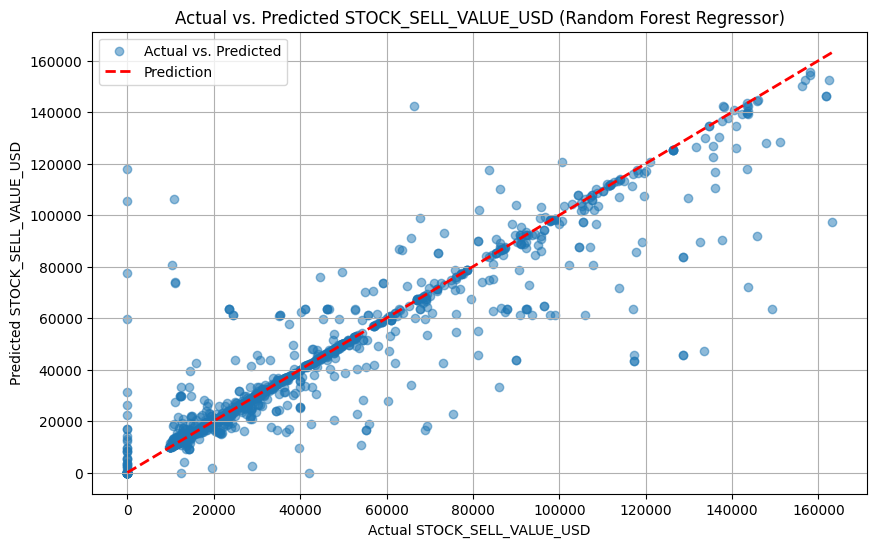

In [ ]:
# Get predictions from the best performing model (Random Forest Regressor)
best_model_name = max(evaluation_metrics, key=lambda k: evaluation_metrics[k]['R2'])
best_model = models[best_model_name]
y_pred_best_model = best_model.predict(X_test)

# Create a scatter plot of actual vs. predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_model, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Plotting the diagonal line
plt.xlabel('Actual STOCK_SELL_VALUE_USD')
plt.ylabel('Predicted STOCK_SELL_VALUE_USD')
plt.title(f'Actual vs. Predicted STOCK_SELL_VALUE_USD ({best_model_name})')
plt.legend(['Actual vs. Predicted', 'Prediction'])
plt.grid(True)
plt.savefig('actual_vs_predicted_scatter_plot.png') # Corrected typo
plt.show()

In [ ]:
sample_input = X_test.iloc[[0]]
predicted_value = best_model.predict(sample_input)
print(f"Predicted STOCK_SELL_VALUE_USD for the sample input: {predicted_value[0]:.2f}")

Predicted STOCK_SELL_VALUE_USD for the sample input: 62303.88


In [ ]:
X_test.iloc[[0]]

,UNRESRICTED_STOCK,PLANT_NAME_SINGAPORE-WAREHOUSE,MATERIAL_NAME_MAT-0002,MATERIAL_NAME_MAT-0003,MATERIAL_NAME_MAT-0004,MATERIAL_NAME_MAT-0006,MATERIAL_NAME_MAT-0007,MATERIAL_NAME_MAT-0008,MATERIAL_NAME_MAT-0009,MATERIAL_NAME_MAT-0011,...,MATERIAL_NAME_MAT-0413,MATERIAL_NAME_MAT-0415,MATERIAL_NAME_MAT-0416,MATERIAL_NAME_MAT-0417,MATERIAL_NAME_MAT-0419,MATERIAL_NAME_MAT-0424,MATERIAL_NAME_MAT-0426,MATERIAL_NAME_MAT-0428,MATERIAL_NAME_MAT-0429,MATERIAL_NAME_MAT-0430
3248,93350,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
material_name_at_index = df.loc[3248, 'MATERIAL_NAME']
print(f"Material name at index: {material_name_at_index}")

Material name at index: MAT-0317


In [ ]:
df

,BALANCE_AS_OF_DATE,PLANT_NAME,MATERIAL_NAME,BATCH_NUMBER,UNRESRICTED_STOCK,STOCK_UNIT,STOCK_SELL_VALUE,CURRENCY,STOCK_SELL_VALUE_USD
0,12/31/2023,CHINA-WAREHOUSE,MAT-0195,8887,133300,KG,418562,CNY,53320.000000
1,12/31/2023,CHINA-WAREHOUSE,MAT-0098,8715A,156575,KG,349162,CNY,44479.235669
2,12/31/2023,CHINA-WAREHOUSE,MAT-0198,9399,157875,KG,495728,CNY,63150.063694
3,12/31/2023,CHINA-WAREHOUSE,MAT-0261,P7905A,203875,KG,1451590,CNY,184915.923567
4,12/31/2023,CHINA-WAREHOUSE,MAT-0142,V4933A,188850,KG,2005587,CNY,255488.789809
...,...,...,...,...,...,...,...,...,...
9400,12/31/2024,SINGAPORE-WAREHOUSE,MAT-0245,P8850A,0,KG,2326135,SGD,325658.900000
9401,12/31/2024,SINGAPORE-WAREHOUSE,MAT-0245,P7393A,0,KG,2062587,SGD,288762.180000
9402,12/31/2024,SINGAPORE-WAREHOUSE,MAT-0191,K1286,325,KG,617500,SGD,86450.000000
9403,12/31/2024,SINGAPORE-WAREHOUSE,MAT-0191,K8761,3000,KG,5700000,SGD,798000.000000


In [ ]:
df.to_csv('inventory_outlier_Predict.csv', index=False)
